In [1]:
import numpy as np
import matplotlib.pyplot as plt
import muram as mio
from astropy.io import fits
import pyflct
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import datashader.transfer_functions as tf
import datashader as ds
from datashader.mpl_ext import dsshow
import pandas as pd
import holoviews as hv
from holoviews.operation.datashader import dynspread
from holoviews.operation.datashader import datashade
import hvplot

In [3]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/cmunrm.ttf'  # Your font path goes here
#font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 14
mpl.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#plt.rc('text', usetex=True)
plt.rc('axes', unicode_minus=False)
width, height = plt.rcParams.get('figure.figsize')

In [4]:
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress

In [5]:
def temporal_avg(data_in, start, end):
    tmp_avg = np.mean(data_in[start:end+1], axis = 0)
    return tmp_avg

In [6]:
def mean_v_from_file(file):
    v_x = fits.open(file)[0].data
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

def mean_vy_from_file(file):
    v_x = fits.open(file)[1].data
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

<h2>12. 03. 2025.</h2>

<p>Here we want to check results of FLCT tracking applied to magnetic field inferred using Milne-Eddington inversion</p>

In [7]:
Vx_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[0].data
Vy_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[1].data

In [8]:
np.shape(Vx_ME_FeI)

(30, 768, 768)

In [9]:
Vxm1 = fits.open("Velocities_TAU_0_1.fits")[1].data # Vy from Velocities.fits as originally thought
Vym1 = fits.open("Velocities_TAU_0_1.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm1 = Vxm1[::3,::2,::2]/1E5
Vym1 = Vym1[::3,::2,::2]/1E5
Vxm1 = Vxm1.transpose(0, 2, 1)
Vym1 = Vym1.transpose(0, 2, 1)

In [10]:
Vxm2 = fits.open("Velocities_TAU_0_010.fits")[1].data # Vy from Velocities.fits as originally thought
Vym2 = fits.open("Velocities_TAU_0_010.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm2 = Vxm2[::3,::2,::2]/1E5
Vym2 = Vym2[::3,::2,::2]/1E5
Vxm2 = Vxm2.transpose(0, 2, 1)
Vym2 = Vym2.transpose(0, 2, 1)

In [11]:
Vx_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")[0].data
Vy_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")[1].data
Vx_Bz1 = Vx_Bz1[:30,::2,::2]
Vy_Bz1 = Vy_Bz1[:30,::2,::2]

In [12]:
Vx_Bz2 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")[0].data
Vy_Bz2 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")[1].data
Vx_Bz2 = Vx_Bz2[:30,::2,::2]
Vy_Bz2 = Vy_Bz2[:30,::2,::2]

In [13]:
np.shape(Vx_Bz2)

(30, 768, 768)

In [14]:
import seaborn as sns

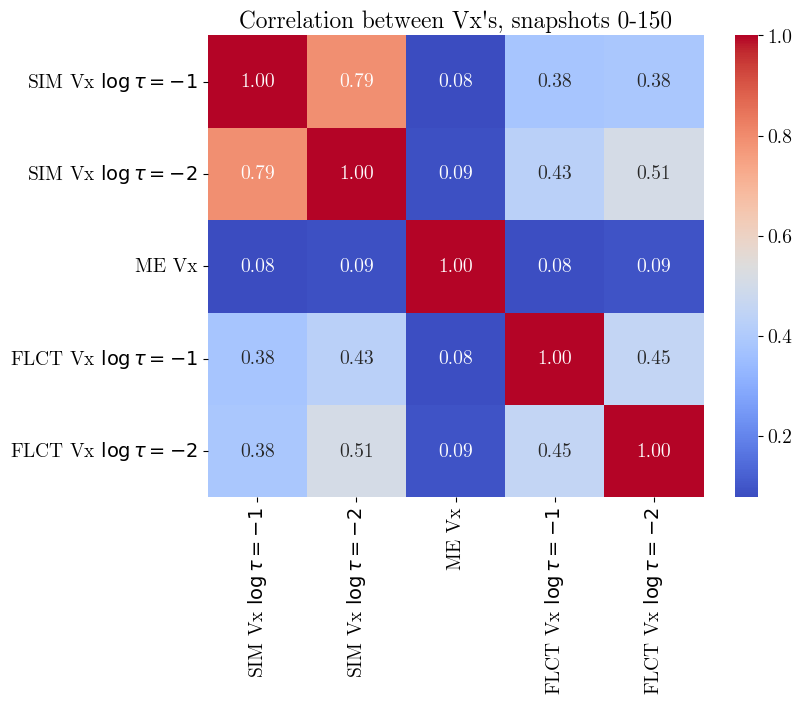

In [15]:
correlation_matrix = np.corrcoef([Vxm1[0,:,:].ravel(), Vxm2[0, :,:].ravel(),
                     Vx_ME_FeI[0,:,:].ravel(), Vx_Bz1[0,:,:].ravel(), 
                     Vx_Bz2[0,:,:].ravel()]) 

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, snapshots 0-150")
plt.savefig("Vx_FE_cor.png", dpi = 70)
plt.show()

<h3>Averaging</h3>

In [16]:
Vxm1_mean = temporal_avg(Vxm1, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym1_mean = temporal_avg(Vym1, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [17]:
Vxm1_filtered600 = gaussian_filter(Vxm1_mean, 22.5/2, mode = "wrap")
Vym1_filtered600 = gaussian_filter(Vym1_mean, 22.5/2, mode = "wrap")

In [18]:
Vxm2_mean = temporal_avg(Vxm2, 0, 90)
#Vxm2_mean = Vxm2_mean/1E5
Vym2_mean = temporal_avg(Vym2, 0, 90)
#Vym2_mean = Vym2_mean/1E5

In [19]:
Vxm2_filtered600 = gaussian_filter(Vxm2_mean, 22.5/2, mode = "wrap")
Vym2_filtered600 = gaussian_filter(Vym2_mean, 22.5/2, mode = "wrap")

In [20]:
Vx_BzFeI_mean = temporal_avg(Vx_ME_FeI, 0, 90)
Vy_BzFeI_mean = temporal_avg(Vy_ME_FeI, 0, 90)

In [21]:
Vx_Bz1_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")
Vy_Bz1_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")

In [22]:
Vx_Bz2_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")
Vy_Bz2_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")

In [23]:
Vx_BzFeI_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")
Vy_BzFeI_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")

In [24]:
Vx_Bz1_mean = temporal_avg(Vx_Bz1, 0, 90)
Vy_Bz1_mean = temporal_avg(Vy_Bz1, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

In [25]:
Vx_Bz2_mean = temporal_avg(Vx_Bz2, 0, 90)
Vy_Bz2_mean = temporal_avg(Vy_Bz2, 0, 90)
#Vx_Bz2_mean = Vx_Bz2_mean[::2,::2]
#Vy_Bz2_mean = Vy_Bz2_mean[::2,::2]

In [26]:
Vx_Bz2_cor = Vx_Bz2_cor[::2,::2]
Vy_Bz2_cor = Vy_Bz2_cor[::2,::2]

In [27]:
Vx_Bz1_cor = Vx_Bz1_cor[::2,::2]
Vy_Bz1_cor = Vy_Bz1_cor[::2,::2]

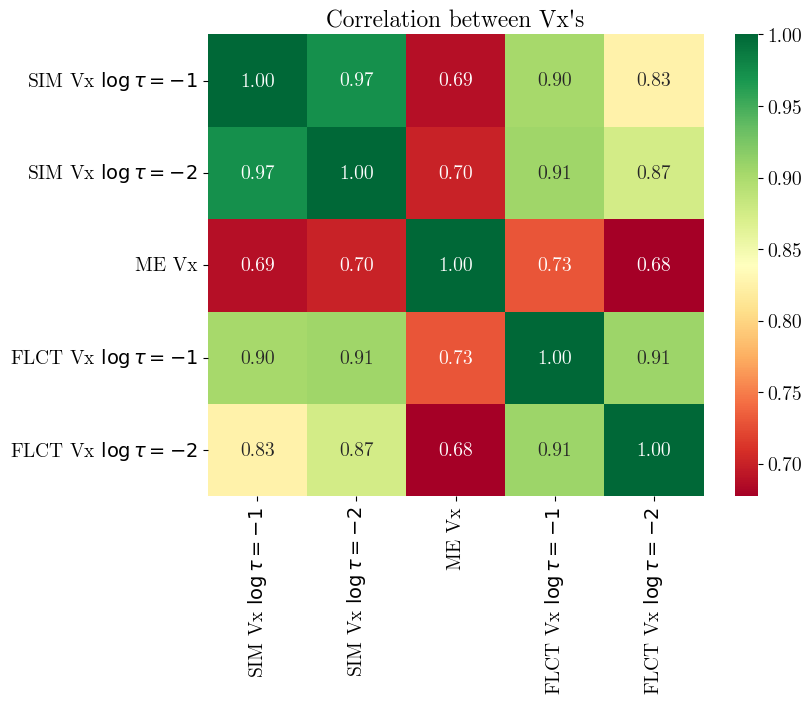

In [28]:
correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(), 
                     Vx_Bz2_cor[:,:].ravel()]) 

fig = plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s")
plt.savefig("Averaged_cor_vel.png", dpi = 70)
plt.show()

Text(0.5, 1.0, "Correlation between Vx's, corrected")

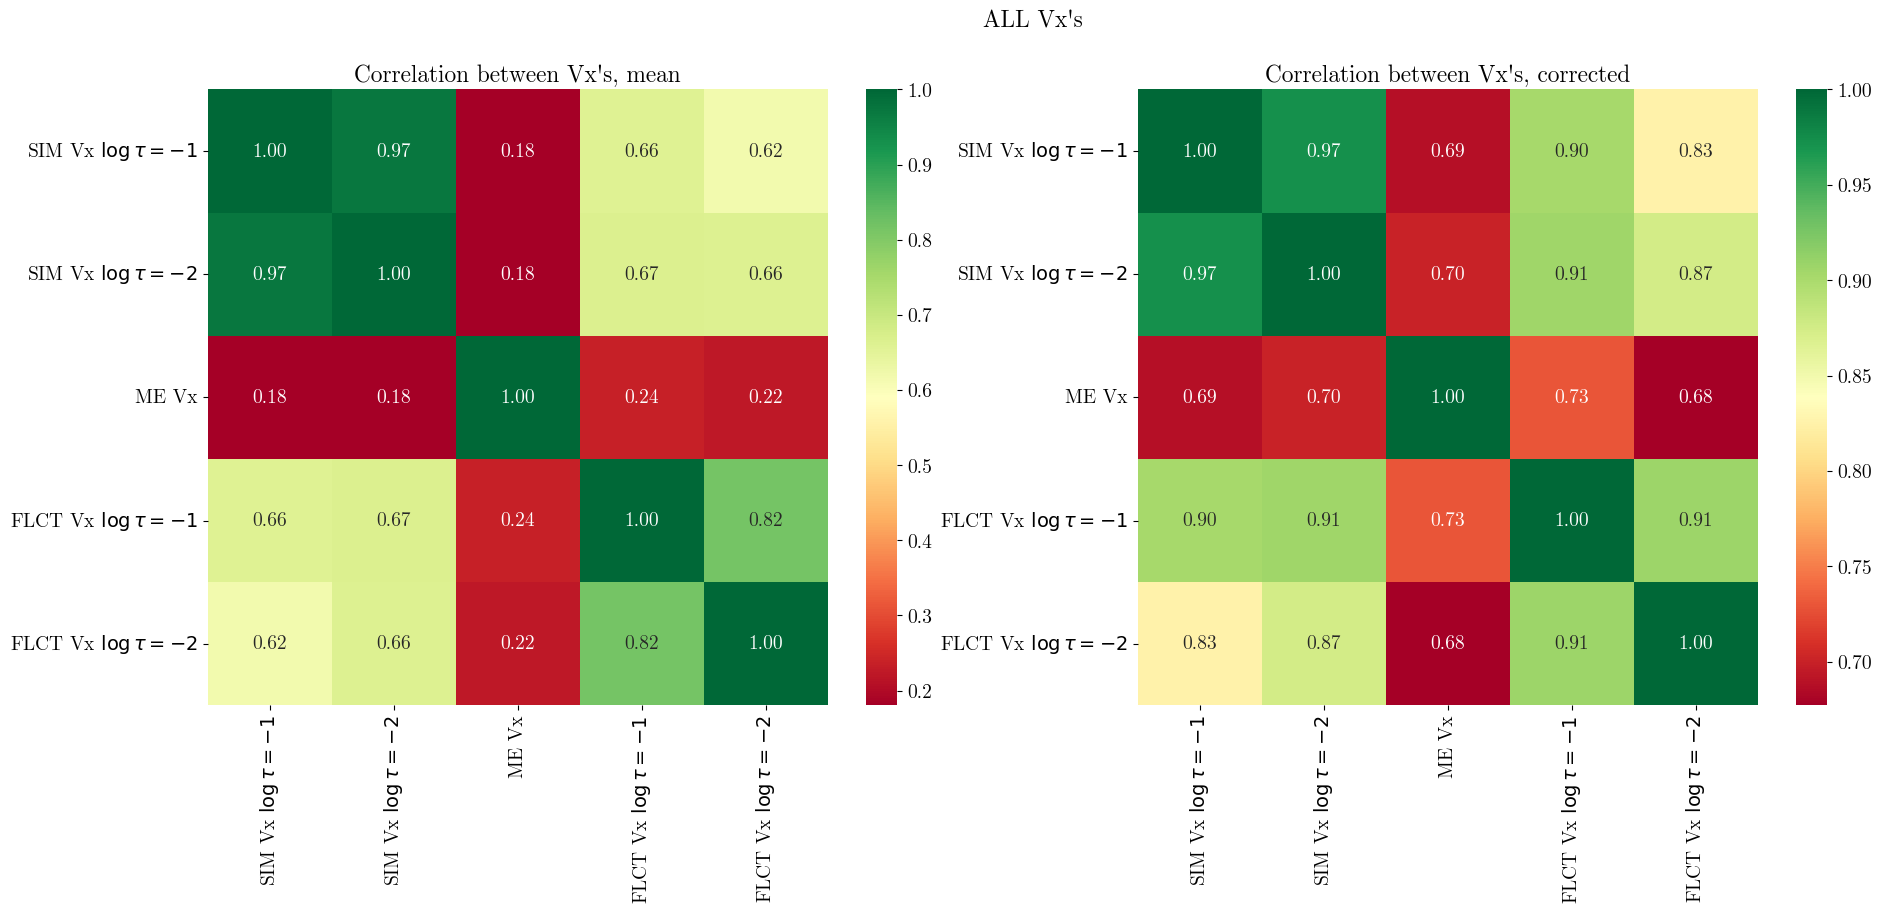

In [29]:
correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_mean[:,:].ravel(), Vx_Bz1_mean[:,:].ravel(), 
                     Vx_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(), 
                     Vx_Bz2_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

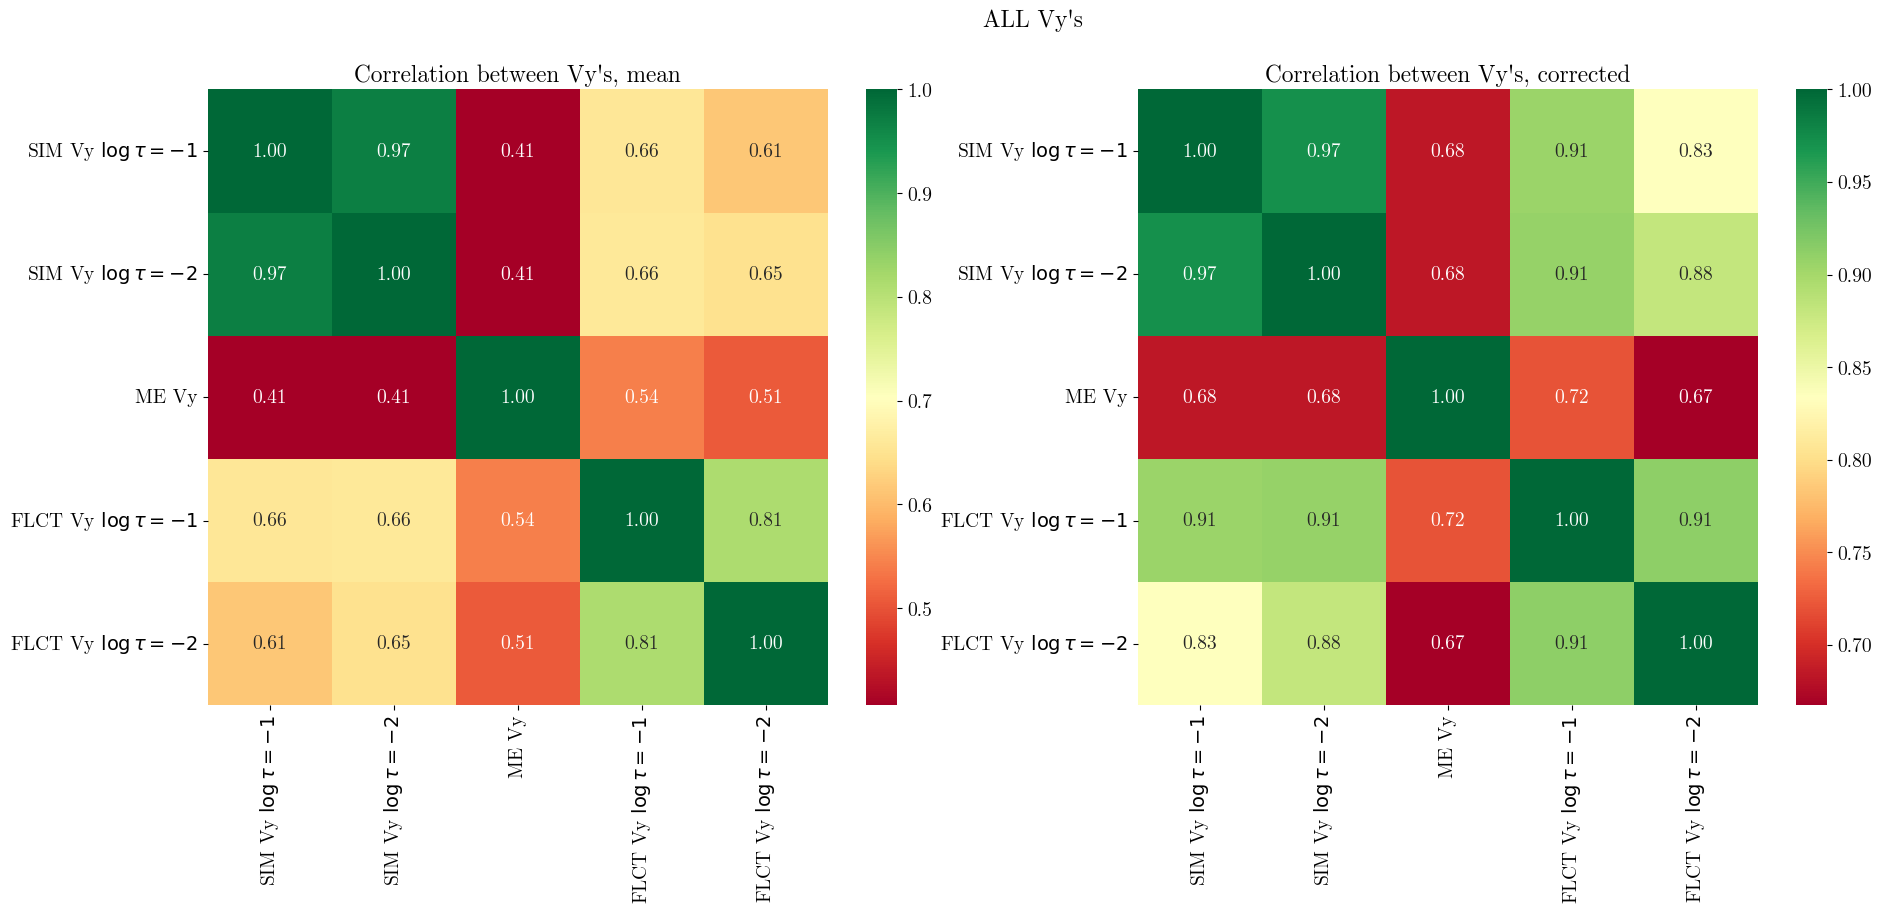

In [30]:
correlation_matrix = np.corrcoef([Vym1_filtered600[:,:].ravel(), Vym2_filtered600[:,:].ravel(),
                     Vy_BzFeI_mean[:,:].ravel(), Vy_Bz1_mean[:,:].ravel(), 
                     Vy_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym1_filtered600[:,:].ravel(), Vym2_filtered600[:,:].ravel(),
                     Vy_BzFeI_cor[:,:].ravel(), Vy_Bz1_cor[:,:].ravel(), 
                     Vy_Bz2_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

<h2>13. 03. 2025</h2>

In [31]:
Vx_ME3_FeI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")[0].data
Vy_ME3_FeI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")[1].data

In [32]:
Vxm1_filtered300 = gaussian_filter(Vxm1_mean, 11.25/2, mode = "wrap")
Vym1_filtered300 = gaussian_filter(Vym1_mean, 11.25/2, mode = "wrap")

In [33]:
Vxm2_filtered300 = gaussian_filter(Vxm2_mean, 11.25/2, mode = "wrap")
Vym2_filtered300 = gaussian_filter(Vym2_mean, 11.25/2, mode = "wrap")

In [34]:
Vx_Bz1_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum1Bz_tracked.fits")
Vy_Bz1_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum1Bz_tracked.fits")

In [35]:
Vx_Bz2_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum2Bz_tracked.fits")
Vy_Bz2_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum2Bz_tracked.fits")

In [36]:
Vx_BzFeI_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")
Vy_BzFeI_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")

In [37]:
Vx_Bz2_cor3 = Vx_Bz2_cor3[::2,::2]
Vy_Bz2_cor3 = Vy_Bz2_cor3[::2,::2]

In [38]:
Vx_Bz1_cor3 = Vx_Bz1_cor3[::2,::2]
Vy_Bz1_cor3 = Vy_Bz1_cor3[::2,::2]

In [39]:
Vx_BzFeI3_mean = temporal_avg(Vx_ME3_FeI, 0, 90)
Vy_BzFeI3_mean = temporal_avg(Vy_ME3_FeI, 0, 90)

Text(0.5, 1.0, "Correlation between Vx's, corrected")

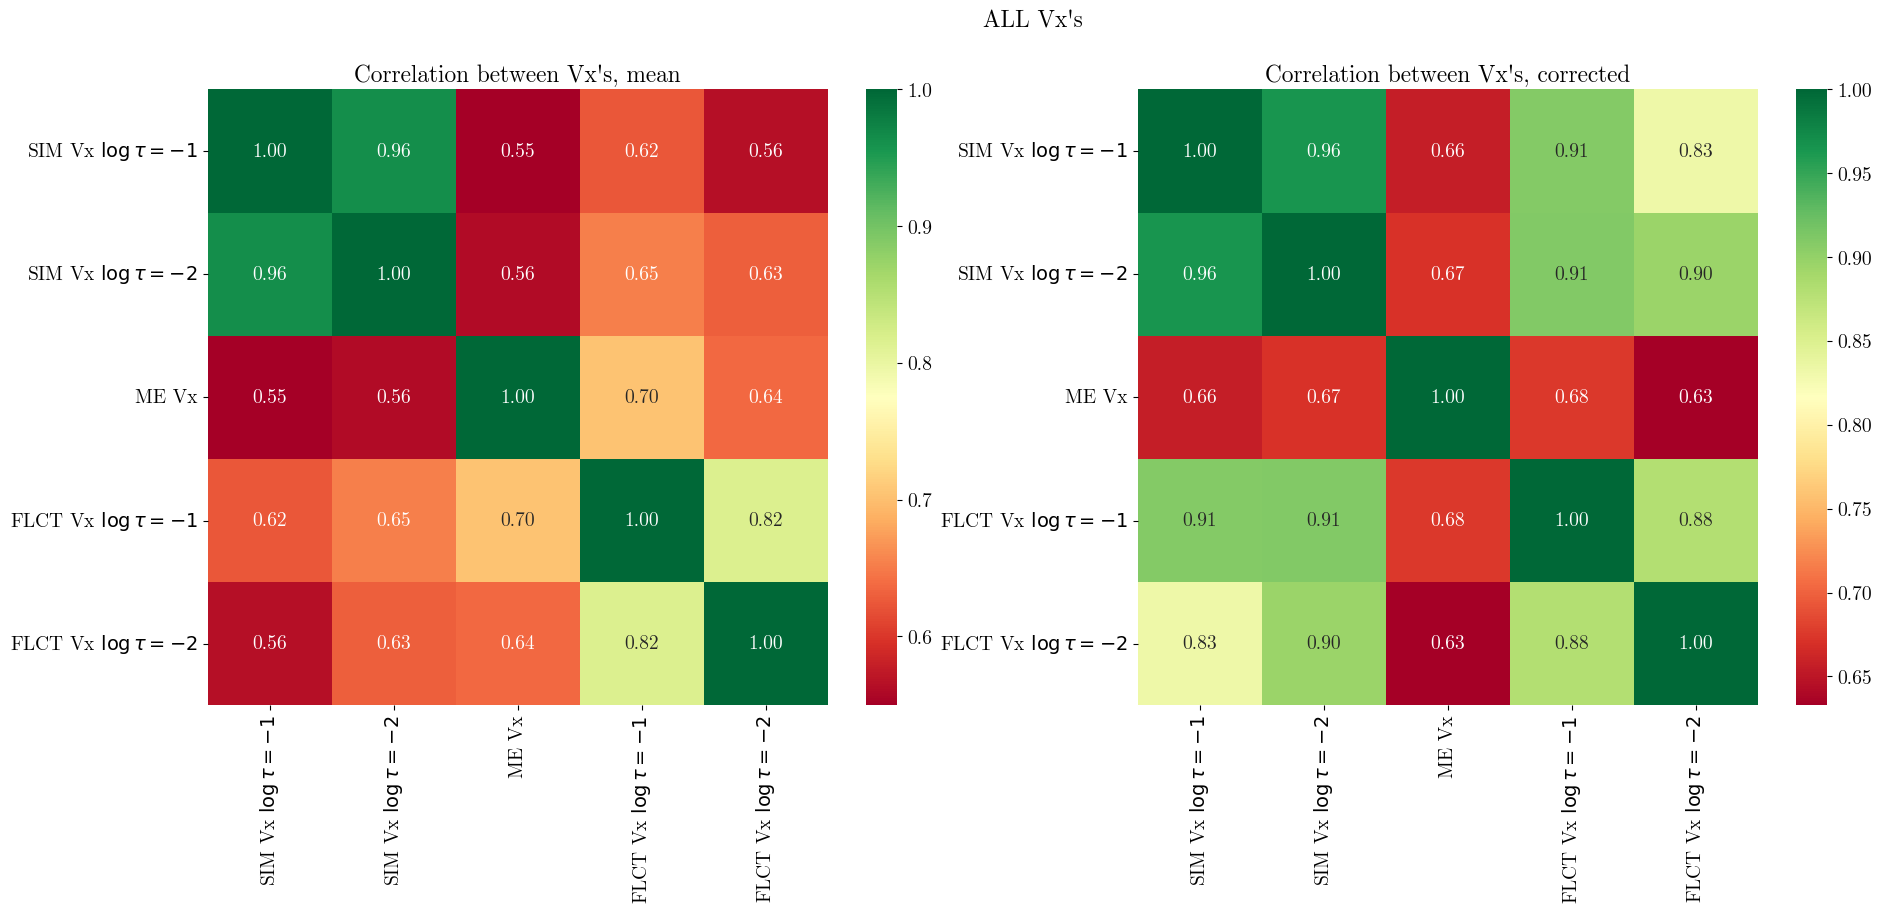

In [40]:
correlation_matrix = np.corrcoef([Vxm1_filtered300[:,:].ravel(), Vxm2_filtered300[:,:].ravel(),
                     Vx_BzFeI3_mean[:,:].ravel(), Vx_Bz1_mean[:,:].ravel(), 
                     Vx_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm1_filtered300[:,:].ravel(), Vxm2_filtered300[:,:].ravel(),
                     Vx_BzFeI_cor3[:,:].ravel(), Vx_Bz1_cor3[:,:].ravel(), 
                     Vx_Bz2_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

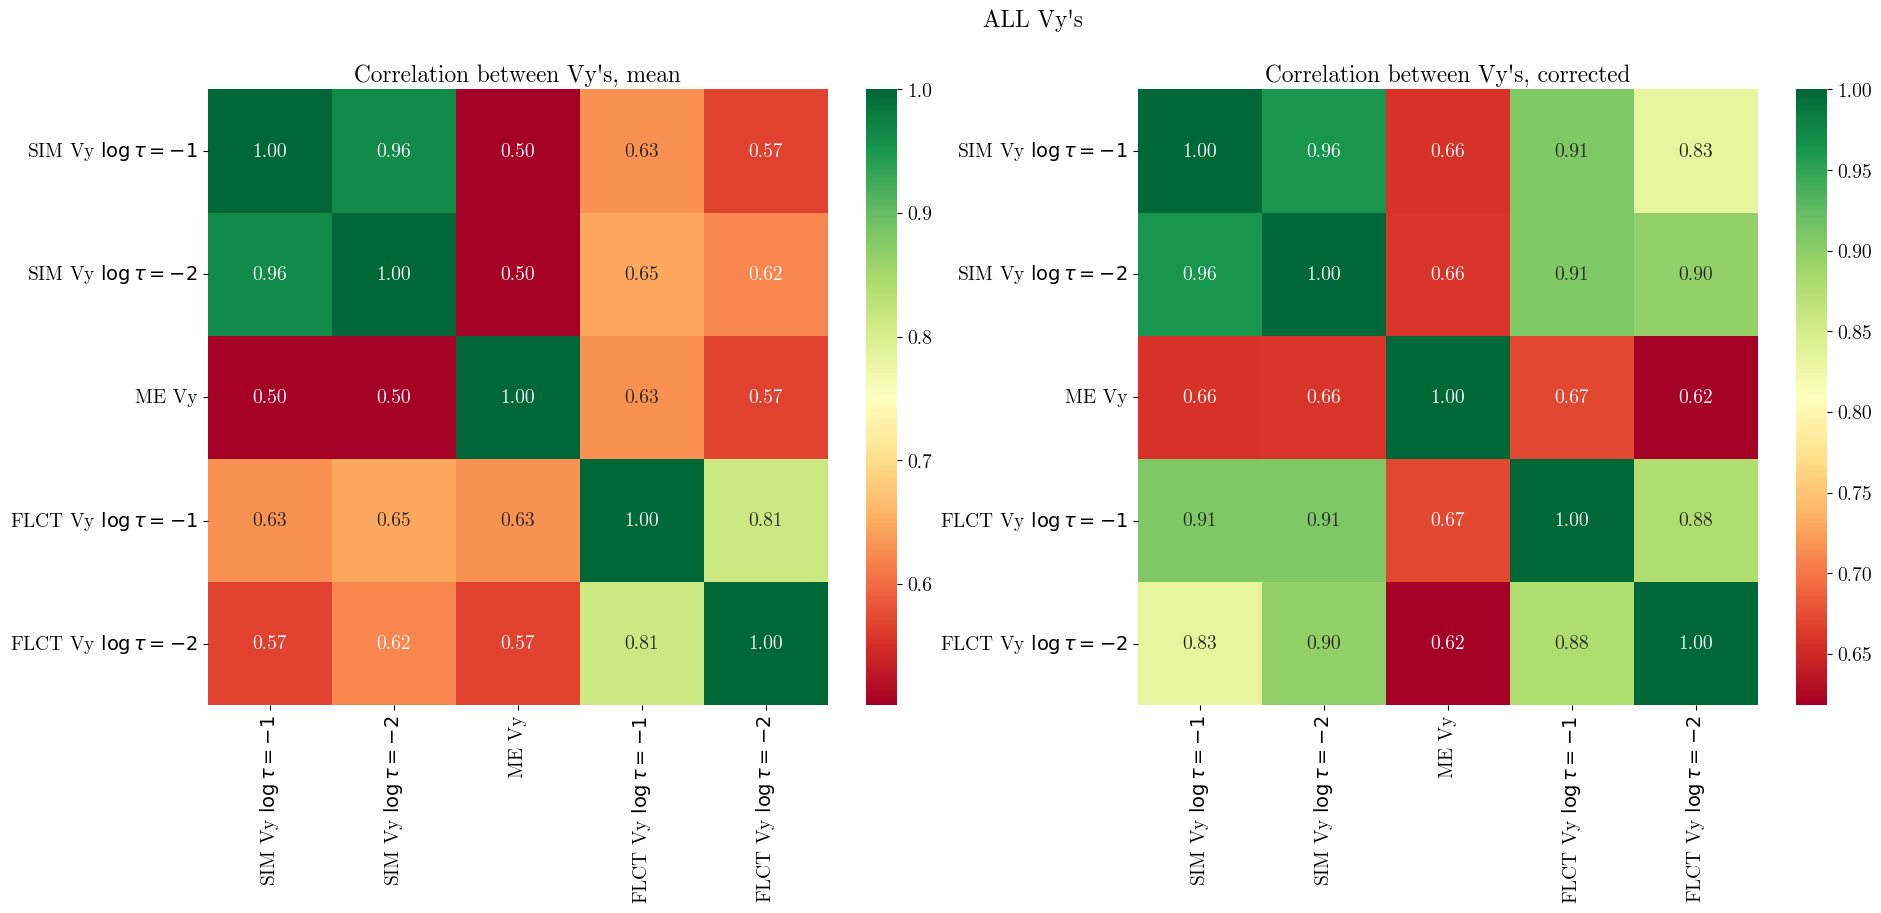

In [41]:
correlation_matrix = np.corrcoef([Vym1_filtered300[:,:].ravel(), Vym2_filtered300[:,:].ravel(),
                     Vy_BzFeI3_mean[:,:].ravel(), Vy_Bz1_mean[:,:].ravel(), 
                     Vy_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym1_filtered300[:,:].ravel(), Vym2_filtered300[:,:].ravel(),
                     Vy_BzFeI_cor3[:,:].ravel(), Vy_Bz1_cor3[:,:].ravel(), 
                     Vy_Bz2_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

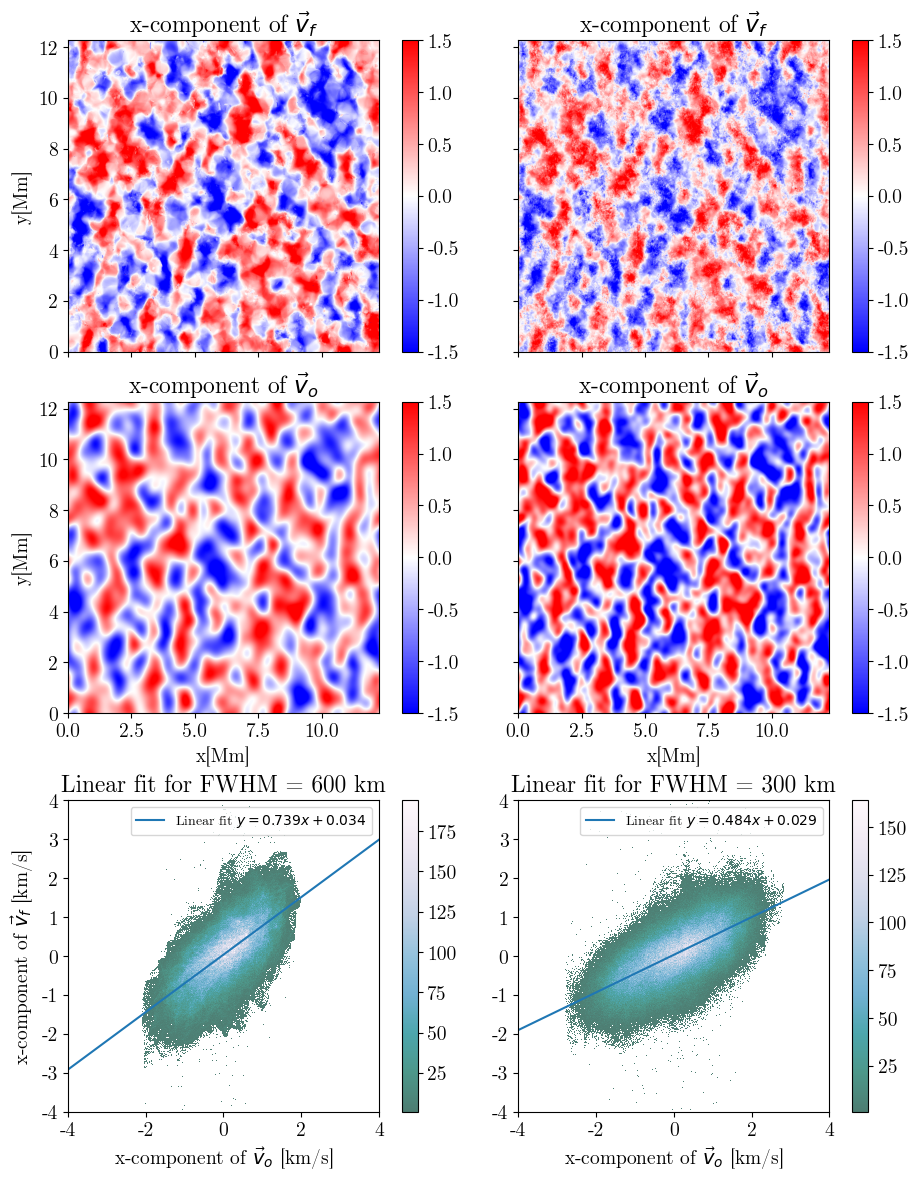

In [42]:
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
f = plt.figure(constrained_layout=True, figsize = (9,11.7))
#plt.suptitle("Linear fit of FLCT Vx and convolved Vx from simulation for FHWM = {1200, 600, 300, 100}km")
# 4x3 plot, velicina A, velicina B, scatter A i B!!!
#ax1 = plt.subplot2grid((4,3), (0,0))
ax1 = f.add_subplot(321)
ax1.set_title("x-component of $\\vec{v}_f$")
#ax1.set_xlabel("x[Mm]")
ax1.set_ylabel("y[Mm]")
ax1.set_xticklabels([])
im1 = ax1.imshow(Vx_BzFeI_cor[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im1)

#ax2 = plt.subplot2grid((4,3), (0,1))
ax2 = f.add_subplot(323)
ax2.set_title("x-component of $\\vec{v}_o$")
ax2.set_xlabel("x[Mm]")
ax2.set_ylabel("y[Mm]")
im2 = ax2.imshow(Vxm1_filtered600[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im2)

#ax3 = plt.subplot2grid((4,3), (0,2))
ax3 = f.add_subplot(325)
ax3.set_title("Linear fit for FWHM = 600 km")                                
ax3.set_ylabel("x-component of $\\vec{v}_f$ [km/s]")
ax3.set_xlabel("x-component of $\\vec{v}_o$ [km/s]")
#ax3.scatter(Vxm1_filtered600.flatten(), Vx_BzFeI_cor.flatten(), s = 0.01, alpha = 0.05, color="red")

df = pd.DataFrame(dict(x = Vxm1_filtered600.flatten(), y = Vx_BzFeI_cor.flatten()))
dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        #vmin=np.min(z),
        #vmax=np.max(z),
        alpha = 0.7,
        norm="linear",
        aspect="equal",
        ax=ax3,
        cmap = "PuBuGn_r",
        x_range = (-4,4),
        y_range = (-4,4)
    )

plt.colorbar(dsartist)
m1, b1, *_ = linregress(Vxm1_filtered600.flatten(), Vx_BzFeI_cor.flatten())
ax3.axline(xy1=(0, b1), slope=m1, label=f'Linear fit $y = {m1:.3f}x {b1:+.3f}$')
ax3.set_xlim(-4.0, 4.0)
ax3.set_ylim(-4.0, 4.0)
plt.legend(fontsize = 10, loc = "best")

#ax4 = plt.subplot2grid((4,3), (1,0))
ax4 = f.add_subplot(322)
ax4.set_title("x-component of $\\vec{v}_f$")
#ax4.set_xlabel("x[Mm]")
#ax4.set_ylabel("y[Mm]")
ax4.set_xticklabels([])
ax4.set_yticklabels([])
im4 = ax4.imshow(Vx_BzFeI_cor3[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im4)

#ax5 = plt.subplot2grid((4,3), (1,1))
ax5 = f.add_subplot(324)
ax5.set_title("x-component of $\\vec{v}_o$")
ax5.set_xlabel("x[Mm]")
#ax5.set_ylabel("y[Mm]")
ax5.set_yticklabels([])
im5 = ax5.imshow(Vxm1_filtered300[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im5)

#ax6 = plt.subplot2grid((4,3), (1,2))
ax6 = f.add_subplot(326)
ax6.set_title("Linear fit for FWHM = 300 km")                                
#ax6.set_ylabel("FLCT Vx[km/s]")
ax6.set_xlabel("x-component of $\\vec{v}_o$ [km/s]")
#ax6.scatter(Vxm1_filtered300.flatten(), Vx_BzFeI_cor3.flatten(), s = 0.01, alpha = 0.05, color="red")

df1 = pd.DataFrame(dict(x = Vxm1_filtered300.flatten(), y = Vx_BzFeI_cor3.flatten()))
dsartist1 = dsshow(
        df1,
        ds.Point("x", "y"),
        ds.count(),
        #vmin=np.min(z),
        #vmax=np.max(z),
        alpha = 0.7,
        norm="linear",
        aspect="equal",
        ax=ax6,
        cmap = "PuBuGn_r",
        #cmap = "inferno"
        x_range = (-4,4),
        y_range = (-4,4)
    )

m2, b2, *_ = linregress(Vxm1_filtered300.flatten(), Vx_BzFeI_cor3.flatten())
ax6.axline(xy1=(0, b2), slope=m2, label=f'Linear fit $y = {m2:.3f}x {b2:+.3f}$')
plt.colorbar(dsartist1)
ax6.set_xlim(-4.0, 4.0)
ax6.set_ylim(-4.0, 4.0)
plt.legend(fontsize = 10, loc='best')



#plt.tight_layout()
plt.savefig("300_600_%2compFeI.png", dpi = 100, bbox_inches = 'tight')

In [43]:
R = pearsonr(Vxm1_filtered600.flatten(), Vx_BzFeI_cor.flatten())
print(R)

PearsonRResult(statistic=np.float64(0.6882519888655942), pvalue=np.float64(0.0))


In [44]:
print(Vxm1_filtered600)

[[ 0.05501394 -0.02104228 -0.09656754 ...  0.27698404  0.20491864
   0.13064101]
 [ 0.10885719  0.03446021 -0.03981754 ...  0.32339674  0.25420925
   0.18241206]
 [ 0.1635412   0.09092652  0.01800749 ...  0.37023243  0.30406788
   0.23489115]
 ...
 [-0.09989754 -0.1801528  -0.25874123 ...  0.14156422  0.06186155
  -0.01891919]
 [-0.04949421 -0.12848356 -0.20616564 ...  0.18596467  0.10862984
   0.0298512 ]
 [ 0.00218186 -0.07540651 -0.152067   ...  0.23113464  0.15634935
   0.07974138]]


In [45]:
print(Vxm1_filtered300)

[[ 0.00300256 -0.18702964 -0.37737322 ...  0.52113     0.3614917
   0.18743922]
 [ 0.12098154 -0.06710862 -0.25750762 ...  0.6215667   0.4696145
   0.3014613 ]
 [ 0.24515961  0.05947741 -0.13061064 ...  0.72659916  0.5828655
   0.42115727]
 ...
 [-0.3055028  -0.4980224  -0.68571573 ...  0.2525088   0.07427461
  -0.11315079]
 [-0.21081685 -0.40312138 -0.5921486  ...  0.33632654  0.16342604
  -0.02036419]
 [-0.10782915 -0.2992852  -0.48918268 ...  0.4259218   0.2592588
   0.07995898]]


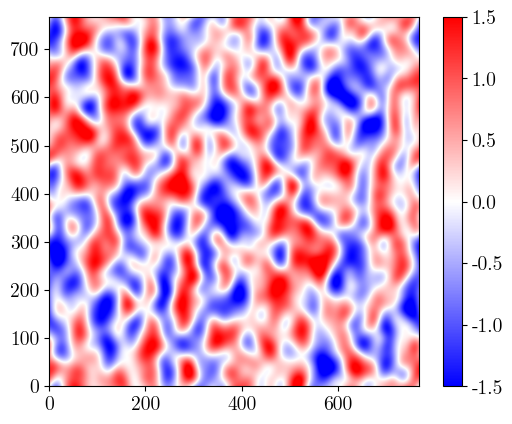

In [46]:
plt.imshow(Vxm1_filtered600[:,:], origin = "lower", cmap = "bwr", vmin = -1.5, vmax = 1.5)
plt.colorbar()

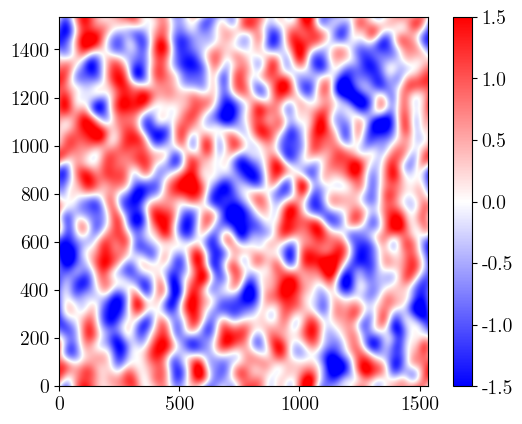

In [47]:
V1 = fits.open("Velocities_TAU_0_1.fits")[1].data
V1= V1[::3]
V1 = V1.transpose(0, 2, 1)
V1_mean = temporal_avg(V1, 0, 90)
V1_mean = V1_mean/1E5
V1600 = gaussian_filter(V1_mean, 22.5, mode = "wrap")
plt.imshow(V1600[:,:], origin = "lower", cmap = "bwr", vmin = -1.5, vmax = 1.5)
plt.colorbar()

In [48]:
print(np.mean(Vxm1_filtered600))
print(np.mean(V1600))

0.051490083
0.051488798


<h2 style ="color:red; font-family:cursive">The correlation depending on sigma in gaussian_filter<br>
    3. row of ALL VX's corrected matrix
</h2>

<h3> $\sigma$ = 22.5/2 or 11.25/2: </h3>

<p>
   FWHM = 600 km - 0.60 | 0.64 | 1.00 | 0.65 | 0.67
</p>

<p>
   FWHM = 300 km - 0.61 | 0.63 | 1.00 | 0.65 | 0.66
</p>

Linear fits: 0.26 (600) | 0.48 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3> $\sigma$ = 22.5/$\sqrt(2)$ or 11.25/$\sqrt(2)$: </h3>

<p>
   FWHM = 600 km - 0.65 | 0.68 | 1.00 | 0.65 | 0.67
</p>

<p>
   FWHM = 300 km - 0.67 | 0.67 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.35 (600) | 0.57 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3> $\sigma$ = 22.5 or 11.25: </h3>

<p>
   FWHM = 600 km - 0.67 | 0.65 | 1.00 | 0.69 | 0.67
</p>

<p>
   FWHM = 300 km - 0.67 | 0.67 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.47 (600) | 0.64 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3> $\sigma$ = 22.5*2 or 11.25*2: </h3>

<p>
   FWHM = 600 km - 0.59 | 0.61 | 1.00 | 0.65 | 0.67
</p>

<p>
   FWHM = 300 km - 0.61 | 0.60 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.79 (600) | 0.95 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3> $\sigma$ = 20 or 10: </h3>

<p>
   FWHM = 600 km - 0.67 | 0.69 | 1.00 | 0.65 | 0.67
</p>

<p>
   FWHM = 300 km - 0.67 | 0.67 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.43 (600) | 0.60 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3> $\sigma$ = 17 or 8: </h3>

<p>
   FWHM = 600 km - 0.65 | 0.68 | 1.00 | 0.65 | 0.67
</p>


<p>
   FWHM = 300 km - 0.67 | 0.67 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.37 (600) | 0.55 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3>$\sigma$ = 16 or 7:</h3>

<p>
   FWHM = 600 km - 0.65 | 0.68 | 1.00 | 0.65 | 0.67
</p>

<p>
   FWHM = 600 km - 0.66 | 0.67 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.35 (600) | 0.52 (300)

<p>------------------------------------------------------------------------------------------</p>

<h2>17. 03. 2025.</h2>
<h2>The rest of optical depths</h2>

In [49]:
Vxm3 = fits.open("Velocities_TAU_0_001.fits")[1].data # Vy from Velocities.fits as originally thought
Vym3 = fits.open("Velocities_TAU_0_001.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm3 = Vxm3[::3,::2,::2]/1E5
Vym3 = Vym3[::3,::2,::2]/1E5
Vxm3 = Vxm3.transpose(0, 2, 1)
Vym3 = Vym3.transpose(0, 2, 1)

In [50]:
Vxm4 = fits.open("Velocities_TAU_0_0001.fits")[1].data # Vy from Velocities.fits as originally thought
Vym4 = fits.open("Velocities_TAU_0_0001.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm4 = Vxm4[::3,::2,::2]/1E5
Vym4 = Vym4[::3,::2,::2]/1E5
Vxm4 = Vxm4.transpose(0, 2, 1)
Vym4 = Vym4.transpose(0, 2, 1)

In [51]:
Vx_Bz3 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")[0].data
Vy_Bz3 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")[1].data
Vx_Bz3 = Vx_Bz3[:30,::2,::2]
Vy_Bz3 = Vy_Bz3[:30,::2,::2]

In [52]:
Vx_Bz4 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")[0].data
Vy_Bz4 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")[1].data
Vx_Bz4 = Vx_Bz4[:30,::2,::2]
Vy_Bz4 = Vy_Bz4[:30,::2,::2]

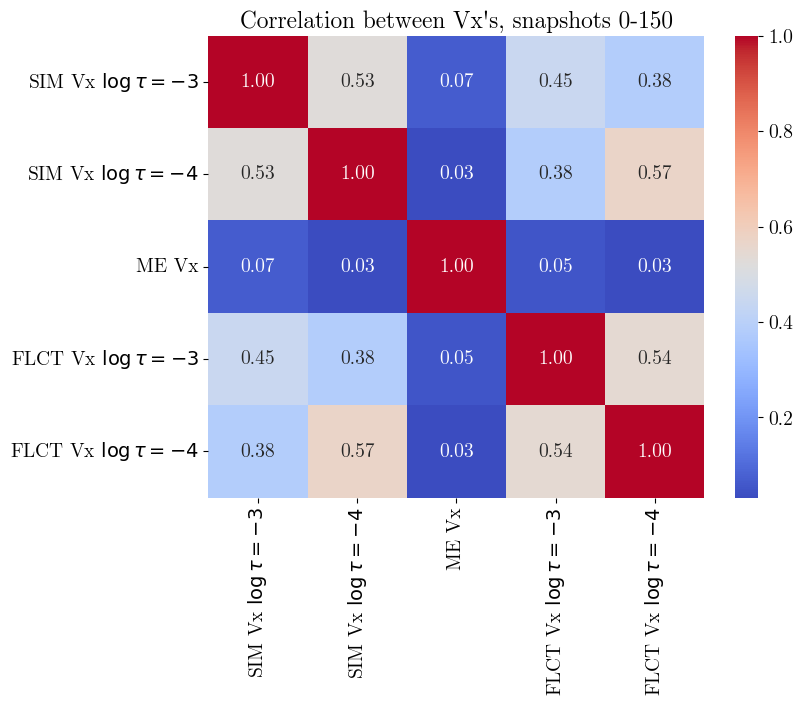

In [53]:
correlation_matrix = np.corrcoef([Vxm3[0,:,:].ravel(), Vxm4[0, :,:].ravel(),
                     Vx_ME_FeI[0,:,:].ravel(), Vx_Bz3[0,:,:].ravel(), 
                     Vx_Bz4[0,:,:].ravel()]) 

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, snapshots 0-150")
plt.savefig("Vx_FE_cor_rest.png", dpi = 70)
plt.show()

In [54]:
Vxm3_mean = temporal_avg(Vxm3, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym3_mean = temporal_avg(Vym3, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [55]:
Vxm4_mean = temporal_avg(Vxm4, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym4_mean = temporal_avg(Vym4, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [56]:
Vxm3_filtered600 = gaussian_filter(Vxm3_mean, 22.5/2, mode = "wrap")
Vym3_filtered600 = gaussian_filter(Vym3_mean, 22.5/2, mode = "wrap")

In [57]:
Vxm4_filtered600 = gaussian_filter(Vxm4_mean, 22.5/2, mode = "wrap")
Vym4_filtered600 = gaussian_filter(Vym4_mean, 22.5/2, mode = "wrap")

In [58]:
Vx_Bz3_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")
Vy_Bz3_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")

In [59]:
Vx_Bz4_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")
Vy_Bz4_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")

In [60]:
Vx_Bz3_cor = Vx_Bz3_cor[::2,::2]
Vy_Bz3_cor = Vy_Bz3_cor[::2,::2]

In [61]:
Vx_Bz4_cor = Vx_Bz4_cor[::2,::2]
Vy_Bz4_cor = Vy_Bz4_cor[::2,::2]

In [62]:
Vx_Bz3_mean = temporal_avg(Vx_Bz3, 0, 90)
Vy_Bz3_mean = temporal_avg(Vy_Bz3, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

In [63]:
Vx_Bz4_mean = temporal_avg(Vx_Bz4, 0, 90)
Vy_Bz4_mean = temporal_avg(Vy_Bz4, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

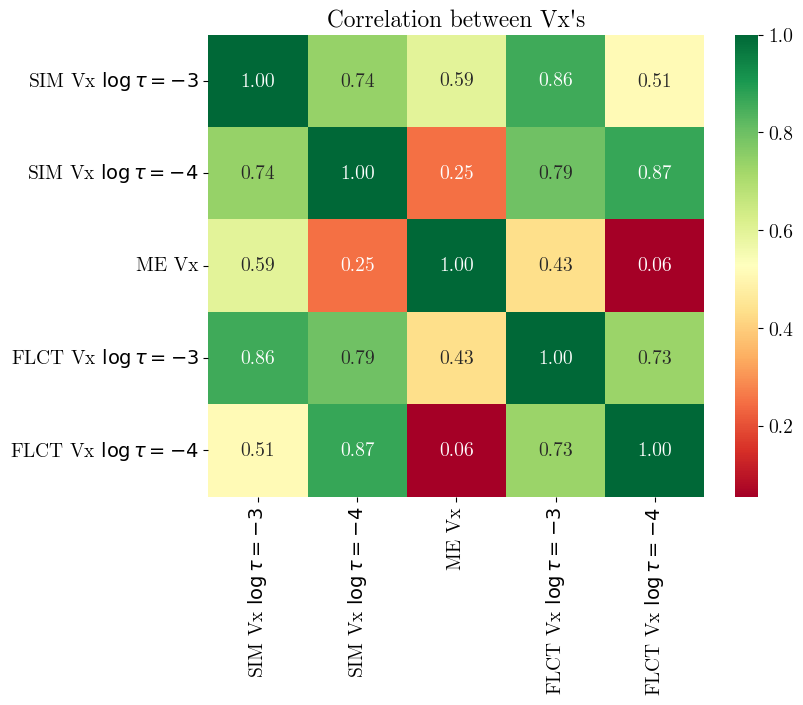

In [64]:
correlation_matrix = np.corrcoef([Vxm3_filtered600[:,:].ravel(), Vxm4_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz3_cor[:,:].ravel(), 
                     Vx_Bz4_cor[:,:].ravel()]) 

fig = plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s")
plt.savefig("rest_Averaged_cor_vel.png", dpi = 70)
plt.show()

Text(0.5, 1.0, "Correlation between Vx's, corrected")

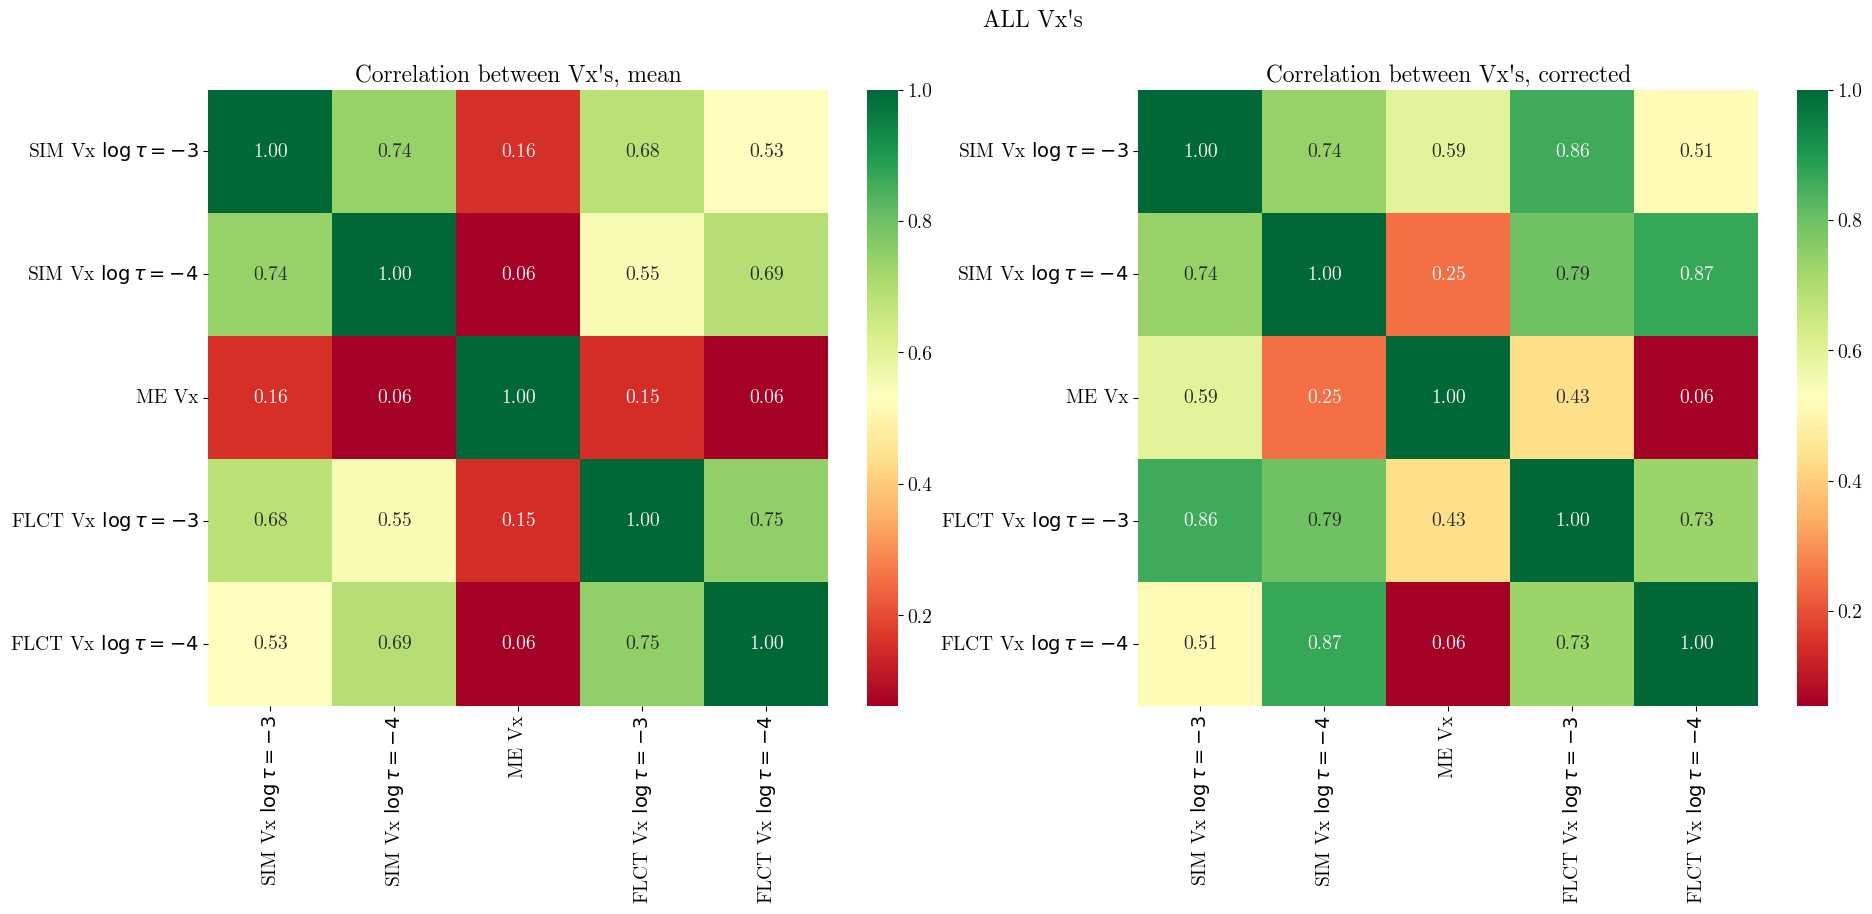

In [65]:
correlation_matrix = np.corrcoef([Vxm3_filtered600[:,:].ravel(), Vxm4_filtered600[:,:].ravel(),
                     Vx_BzFeI_mean[:,:].ravel(), Vx_Bz3_mean[:,:].ravel(), 
                     Vx_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm3_filtered600[:,:].ravel(), Vxm4_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz3_cor[:,:].ravel(), 
                     Vx_Bz4_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

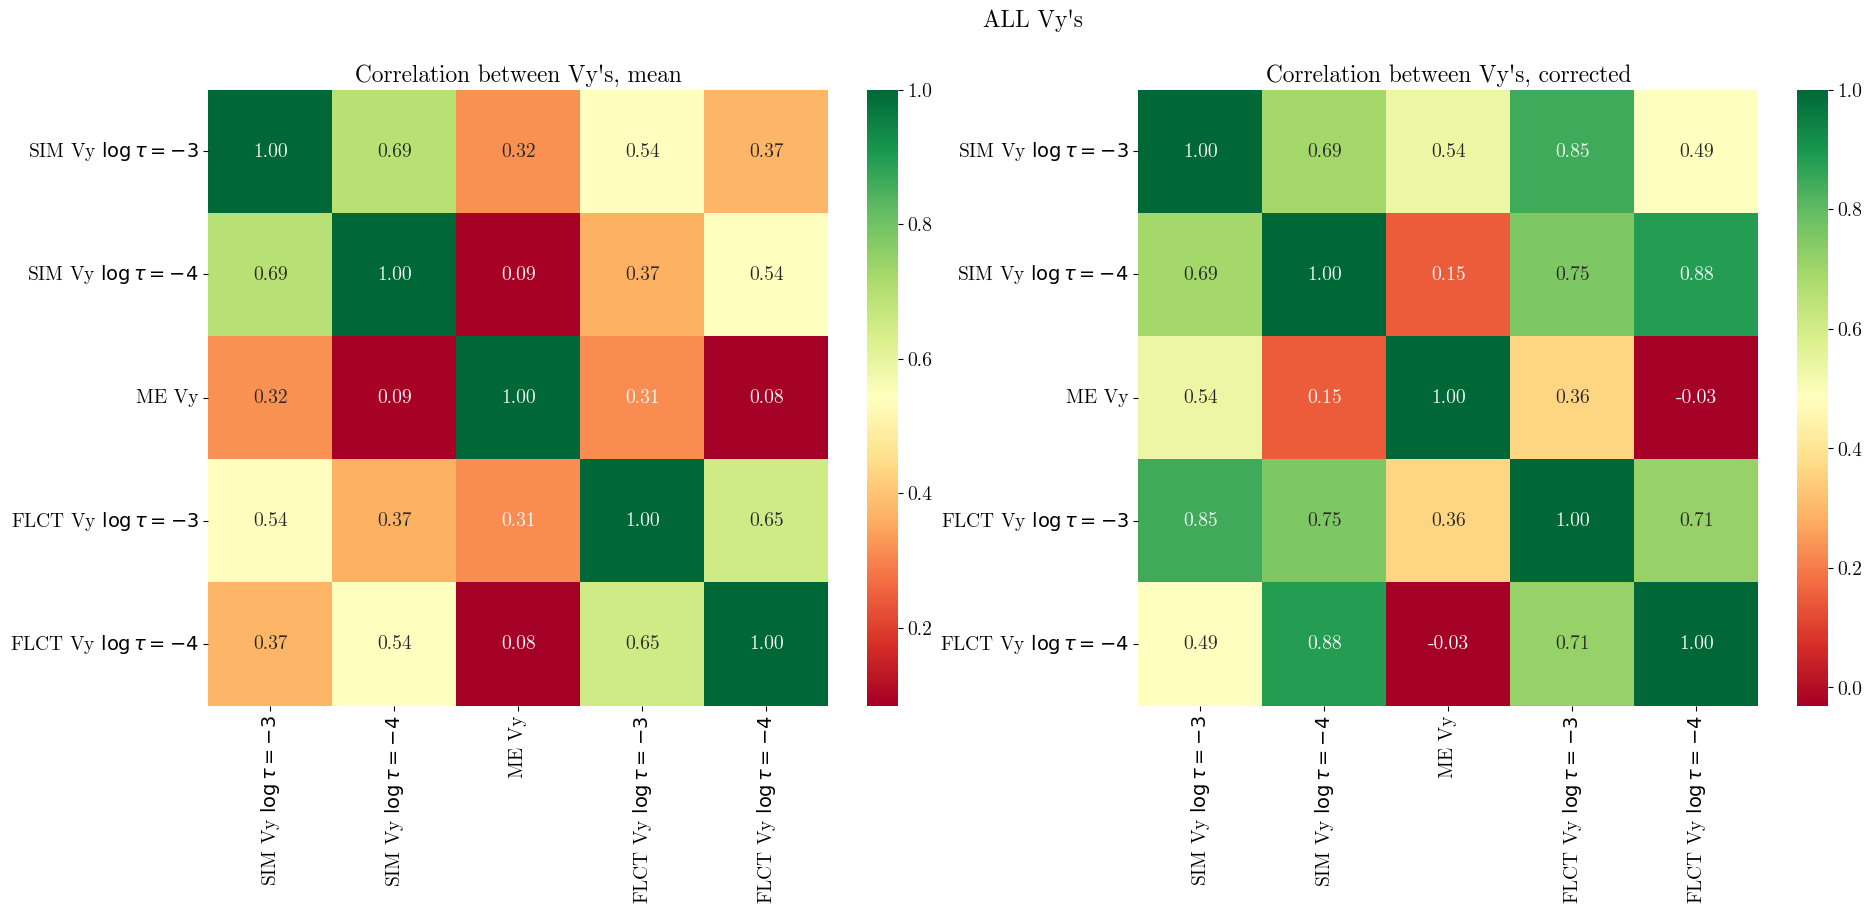

In [66]:
correlation_matrix = np.corrcoef([Vym3_filtered600[:,:].ravel(), Vym4_filtered600[:,:].ravel(),
                     Vy_BzFeI_mean[:,:].ravel(), Vy_Bz3_mean[:,:].ravel(), 
                     Vy_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym3_filtered600[:,:].ravel(), Vym4_filtered600[:,:].ravel(),
                     Vy_BzFeI_cor[:,:].ravel(), Vy_Bz3_cor[:,:].ravel(), 
                     Vy_Bz4_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

<h3>FWHM = 300 km</h3>

In [67]:
Vxm3_filtered300 = gaussian_filter(Vxm3_mean, 11.25/2, mode = "wrap")
Vym3_filtered300 = gaussian_filter(Vym3_mean, 11.25/2, mode = "wrap")

In [68]:
Vxm4_filtered300 = gaussian_filter(Vxm4_mean, 11.25/2, mode = "wrap")
Vym4_filtered300 = gaussian_filter(Vym4_mean, 11.25/2, mode = "wrap")

In [69]:
Vx_Bz3_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum3Bz_tracked.fits")
Vy_Bz3_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum3Bz_tracked.fits")

In [70]:
Vx_Bz4_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum4Bz_tracked.fits")
Vy_Bz4_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum4Bz_tracked.fits")

In [71]:
Vx_Bz3_cor3 = Vx_Bz3_cor3[::2,::2]
Vy_Bz3_cor3 = Vy_Bz3_cor3[::2,::2]

In [72]:
Vx_Bz4_cor3 = Vx_Bz4_cor3[::2,::2]
Vy_Bz4_cor3 = Vy_Bz4_cor3[::2,::2]

Text(0.5, 1.0, "Correlation between Vx's, corrected")

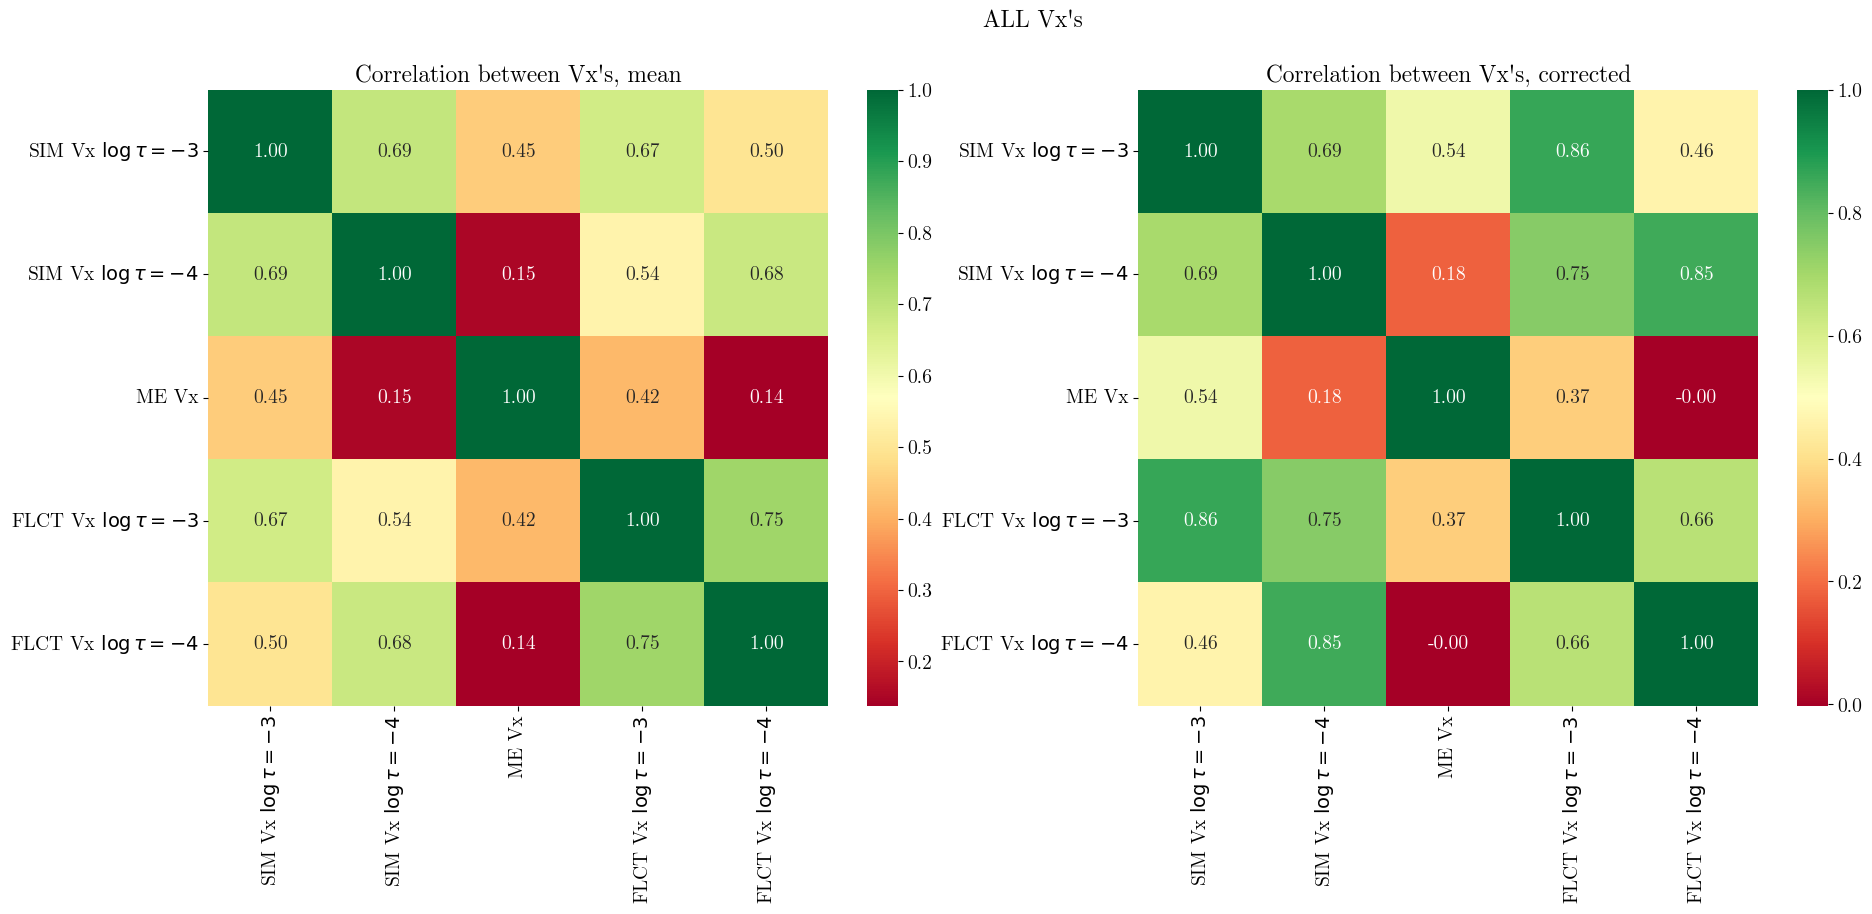

In [73]:
correlation_matrix = np.corrcoef([Vxm3_filtered300[:,:].ravel(), Vxm4_filtered300[:,:].ravel(),
                     Vx_BzFeI3_mean[:,:].ravel(), Vx_Bz3_mean[:,:].ravel(), 
                     Vx_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm3_filtered300[:,:].ravel(), Vxm4_filtered300[:,:].ravel(),
                     Vx_BzFeI_cor3[:,:].ravel(), Vx_Bz3_cor3[:,:].ravel(), 
                     Vx_Bz4_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

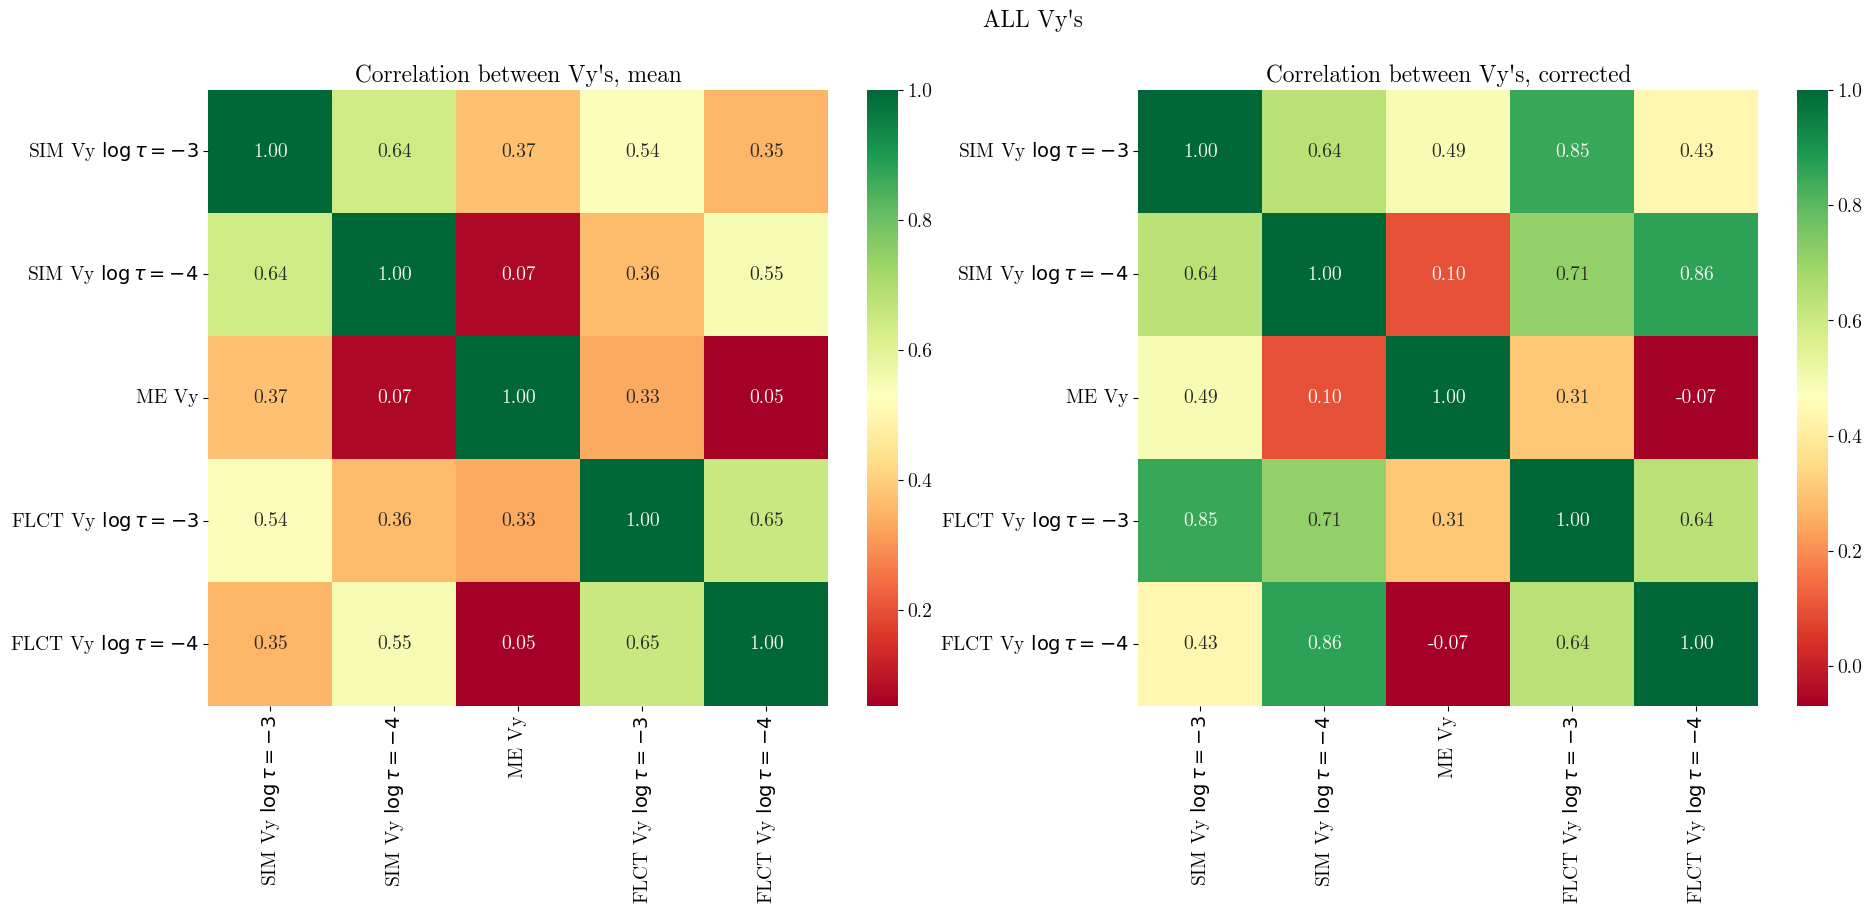

In [74]:
correlation_matrix = np.corrcoef([Vym3_filtered300[:,:].ravel(), Vym4_filtered300[:,:].ravel(),
                     Vy_BzFeI3_mean[:,:].ravel(), Vy_Bz3_mean[:,:].ravel(), 
                     Vy_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym3_filtered300[:,:].ravel(), Vym4_filtered300[:,:].ravel(),
                     Vy_BzFeI_cor3[:,:].ravel(), Vy_Bz3_cor3[:,:].ravel(), 
                     Vy_Bz4_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

/tmp/ipykernel_13086/2162386975.py:64: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("300_600_%2compFeI_taum4.png", dpi = 75, bbox_inches = 'tight')
/home/mistflow/anaconda3/envs/FLCT/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


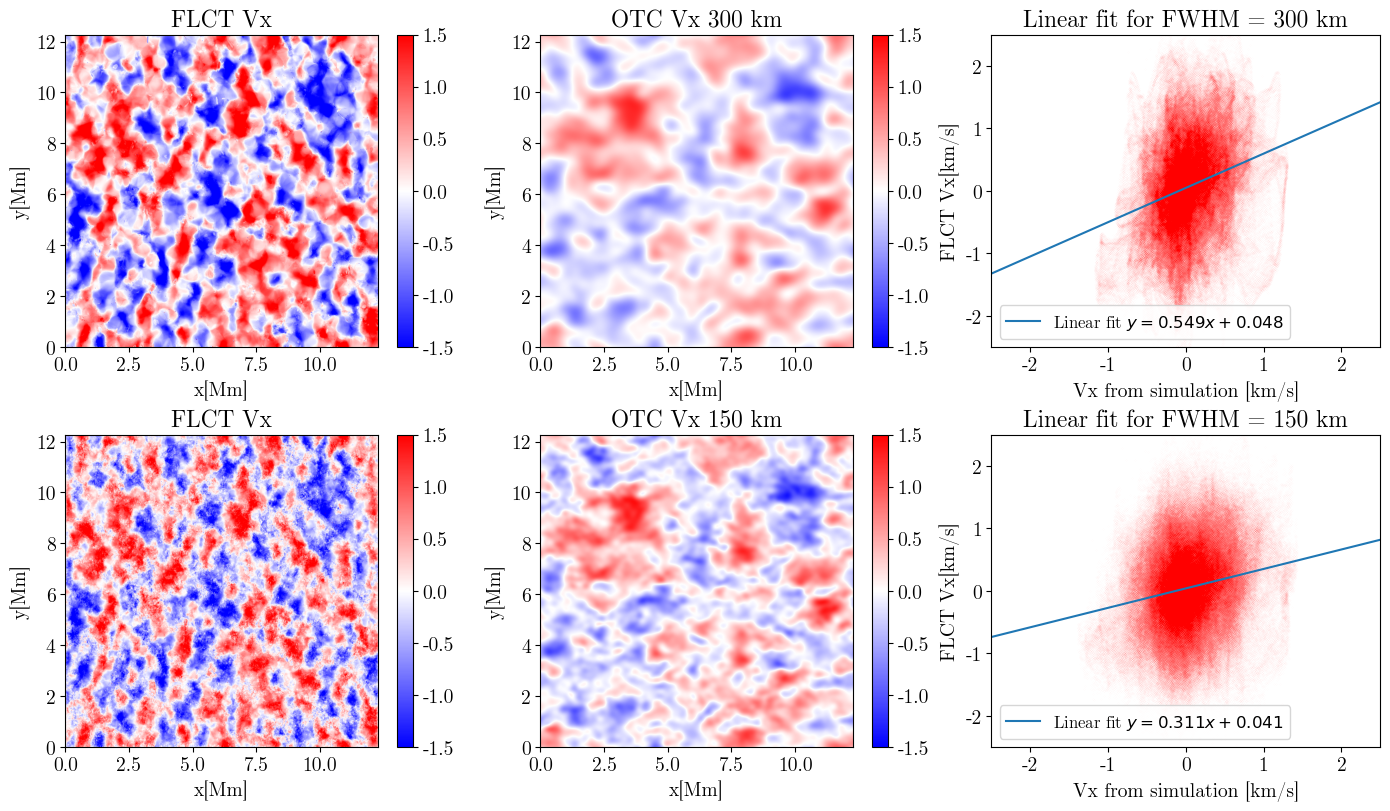

In [75]:
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
f = plt.figure(constrained_layout=True, figsize = (14, 8))
#plt.suptitle("Linear fit of FLCT Vx and convolved Vx from simulation for FHWM = {1200, 600, 300, 100}km")
# 4x3 plot, velicina A, velicina B, scatter A i B!!!
#ax1 = plt.subplot2grid((4,3), (0,0))
ax1 = f.add_subplot(231)
ax1.set_title("FLCT Vx")
ax1.set_xlabel("x[Mm]")
ax1.set_ylabel("y[Mm]")
im1 = ax1.imshow(Vx_BzFeI_cor[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im1)

#ax2 = plt.subplot2grid((4,3), (0,1))
ax2 = f.add_subplot(232)
ax2.set_title("OTC Vx 300 km")
ax2.set_xlabel("x[Mm]")
ax2.set_ylabel("y[Mm]")
im2 = ax2.imshow(Vxm4_filtered600[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im2)

#ax3 = plt.subplot2grid((4,3), (0,2))
ax3 = f.add_subplot(233)
ax3.set_title("Linear fit for FWHM = 300 km")                                
ax3.set_ylabel("FLCT Vx[km/s]")
ax3.set_xlabel("Vx from simulation [km/s]")
ax3.scatter(Vxm4_filtered600.flatten(), Vx_BzFeI_cor.flatten(), s = 0.01, alpha = 0.05, color="red")
m3, b3, *_ = linregress(Vxm4_filtered600.flatten(), Vx_BzFeI_cor.flatten())
ax3.axline(xy1=(0, b3), slope=m3, label=f'Linear fit $y = {m3:.3f}x {b3:+.3f}$')
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5)
plt.legend(fontsize = 12)

#ax4 = plt.subplot2grid((4,3), (1,0))
ax4 = f.add_subplot(234)
ax4.set_title("FLCT Vx")
ax4.set_xlabel("x[Mm]")
ax4.set_ylabel("y[Mm]")
im4 = ax4.imshow(Vx_BzFeI_cor3[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im4)

#ax5 = plt.subplot2grid((4,3), (1,1))
ax5 = f.add_subplot(235)
ax5.set_title("OTC Vx 150 km")
ax5.set_xlabel("x[Mm]")
ax5.set_ylabel("y[Mm]")
im5 = ax5.imshow(Vxm4_filtered300[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im5)

#ax6 = plt.subplot2grid((4,3), (1,2))
ax6 = f.add_subplot(236)
ax6.set_title("Linear fit for FWHM = 150 km")                                
ax6.set_ylabel("FLCT Vx[km/s]")
ax6.set_xlabel("Vx from simulation [km/s]")
ax6.scatter(Vxm4_filtered300.flatten(), Vx_BzFeI_cor3.flatten(), s = 0.01, alpha = 0.05, color="red")
m4, b4, *_ = linregress(Vxm4_filtered300.flatten(), Vx_BzFeI_cor3.flatten())
ax6.axline(xy1=(0, b4), slope=m4, label=f'Linear fit $y = {m4:.3f}x {b4:+.3f}$')
ax6.set_xlim(-2.5, 2.5)
ax6.set_ylim(-2.5, 2.5)
plt.legend(fontsize = 12)



#plt.tight_layout()
plt.savefig("300_600_%2compFeI_taum4.png", dpi = 75, bbox_inches = 'tight')

<h2>27. 03. 2025. - CS calculation</h2>

In [76]:
from numpy import dot
from numpy.linalg import norm
def CS_calc(a, b):
    s = 0
    for j in range(len(a)):
        cos_sim = dot(a[j], b[j])/(norm(a[j])*norm(b[j]))
        s = s + cos_sim
    return s/len(a)

<h3>FWHM = 600km, all $\tau$-s</h3>

In [77]:
cs_1_Fe_600x = CS_calc(Vxm1_filtered600.flatten(), Vx_BzFeI_cor.flatten())
print(cs_1_Fe_600x)

0.5281745062934028


In [78]:
cs_1_Fe_600y = CS_calc(Vym1_filtered600.flatten(), Vy_BzFeI_cor.flatten())
print(cs_1_Fe_600y)

0.4890272352430556


In [79]:
cs_2_Fe_600x = CS_calc(Vxm2_filtered600.flatten(), Vx_BzFeI_cor.flatten())
print(cs_2_Fe_600x)

0.5397372775607638


In [80]:
cs_2_Fe_600y = CS_calc(Vym2_filtered600.flatten(), Vy_BzFeI_cor.flatten())
print(cs_2_Fe_600y)

0.4984910753038194


In [81]:
cs_3_Fe_600x = CS_calc(Vxm3_filtered600.flatten(), Vx_BzFeI_cor.flatten())
print(cs_3_Fe_600x)

0.4481540256076389


In [82]:
cs_3_Fe_600y = CS_calc(Vym3_filtered600.flatten(), Vy_BzFeI_cor.flatten())
print(cs_3_Fe_600y)

0.3612569173177083


In [83]:
cs_4_Fe_600x = CS_calc(Vxm4_filtered600.flatten(), Vx_BzFeI_cor.flatten())
print(cs_4_Fe_600x)

0.2024807400173611


In [84]:
cs_4_Fe_600y = CS_calc(Vym4_filtered600.flatten(), Vy_BzFeI_cor.flatten())
print(cs_4_Fe_600y)

0.12273491753472222


<h3>FWHM = 300km, all $\tau$-s</h3>

In [85]:
cs_1_Fe_300x = CS_calc(Vxm1_filtered300.flatten(), Vx_BzFeI_cor3.flatten())
print(cs_1_Fe_300x)

0.4961751302083333


In [86]:
cs_1_Fe_300y = CS_calc(Vym1_filtered300.flatten(), Vy_BzFeI_cor3.flatten())
print(cs_1_Fe_300y)

0.4893968370225694


In [87]:
cs_2_Fe_300x = CS_calc(Vxm2_filtered300.flatten(), Vx_BzFeI_cor3.flatten())
print(cs_2_Fe_300x)

0.5109965006510416


In [88]:
cs_2_Fe_300y = CS_calc(Vym2_filtered300.flatten(), Vy_BzFeI_cor3.flatten())
print(cs_2_Fe_300y)

0.4902513292100694


In [89]:
cs_3_Fe_300x = CS_calc(Vxm3_filtered300.flatten(), Vx_BzFeI_cor3.flatten())
print(cs_3_Fe_300x)

0.39556884765625


In [90]:
cs_3_Fe_300y = CS_calc(Vym3_filtered300.flatten(), Vy_BzFeI_cor3.flatten())
print(cs_3_Fe_300y)

0.333740234375


In [91]:
cs_4_Fe_300x = CS_calc(Vxm4_filtered300.flatten(), Vx_BzFeI_cor3.flatten())
print(cs_4_Fe_300x)

0.12357584635416667


In [92]:
cs_4_Fe_300y = CS_calc(Vym4_filtered300.flatten(), Vy_BzFeI_cor3.flatten())
print(cs_4_Fe_300y)

0.07883368598090278


<h2>02. 04. 2025</h2>

In [93]:
logt = [-1.0, -2.0, -3.0, -4.0]
fwhm6x_cor = [pearsonr(Vxm1_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0],
            pearsonr(Vxm2_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0],
             pearsonr(Vxm3_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0],
             pearsonr(Vxm4_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0]]
fwhm6y_cor = [pearsonr(Vym1_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0],
            pearsonr(Vym2_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0],
             pearsonr(Vym3_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0],
             pearsonr(Vym4_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0]]

fwhm3x_cor = [pearsonr(Vxm1_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0],
            pearsonr(Vxm2_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0],
             pearsonr(Vxm3_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0],
             pearsonr(Vxm4_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0]]

fwhm3y_cor = [pearsonr(Vym1_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0],
            pearsonr(Vym2_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0],
             pearsonr(Vym3_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0],
             pearsonr(Vym4_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0]]

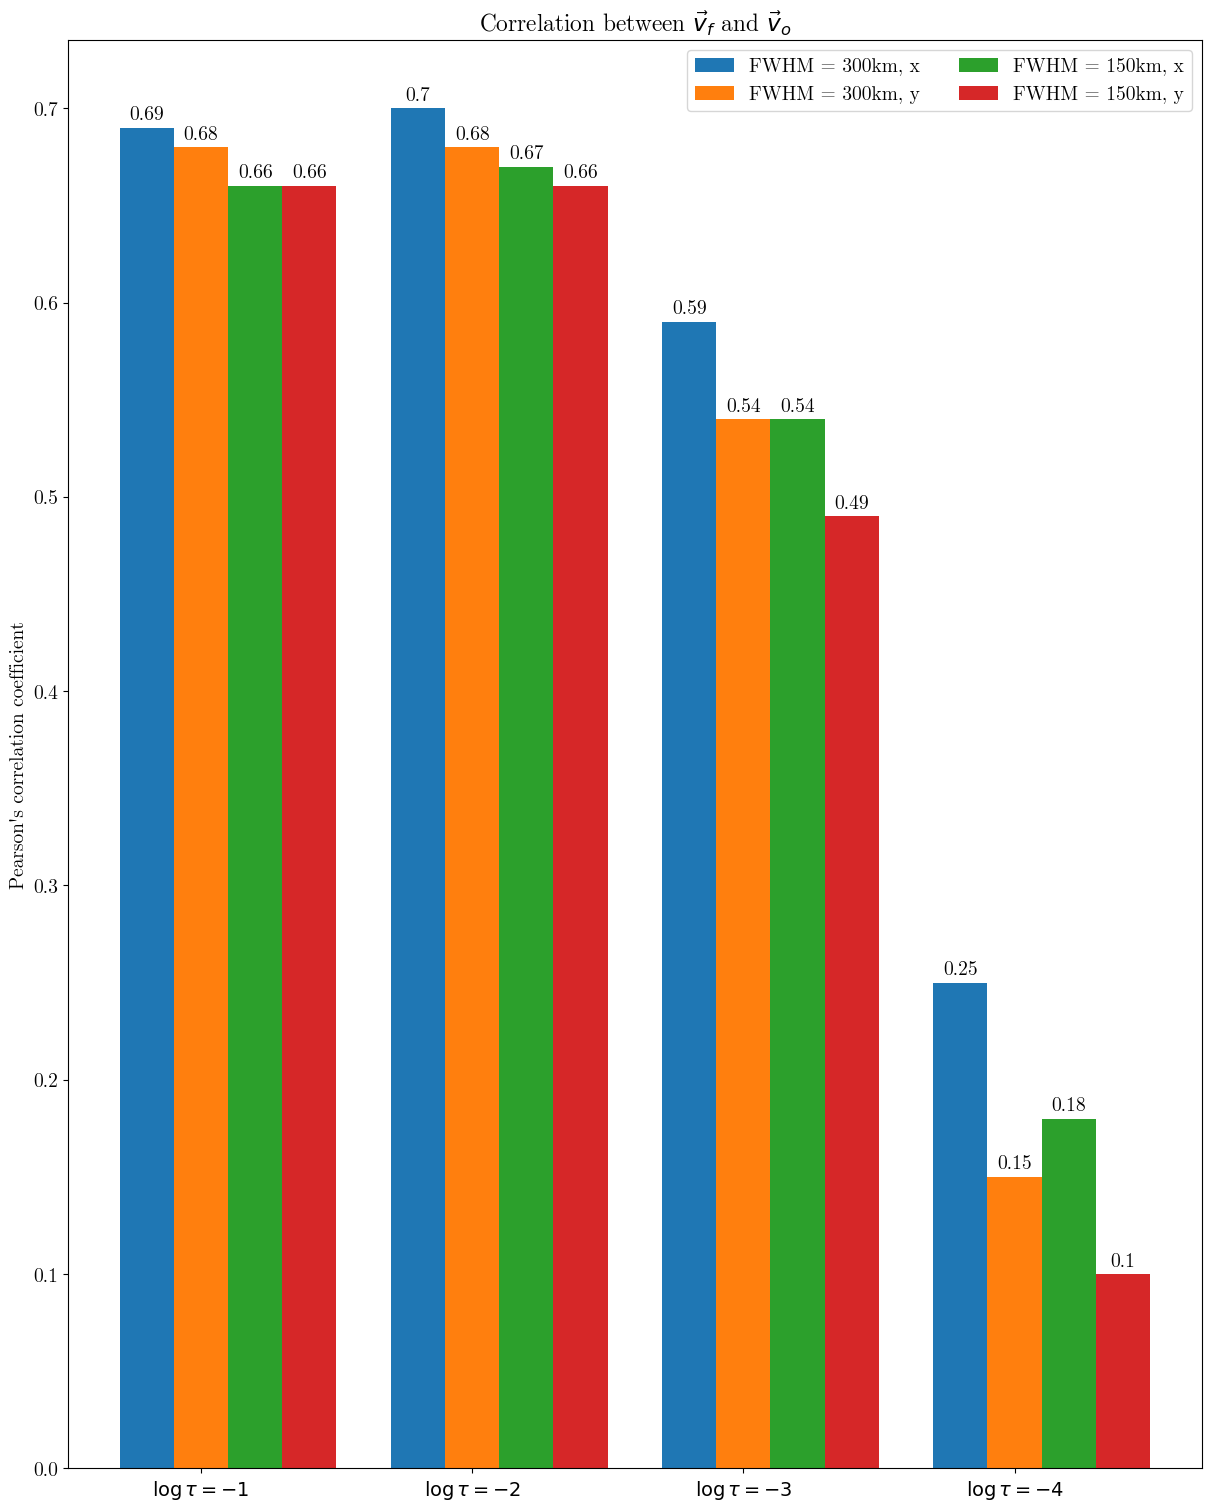

In [94]:
species = ("$\log\\tau=-1$", "$\log\\tau=-2$", "$\log\\tau=-3$", "$\log\\tau=-4$")
penguin_means = {
    'FWHM = 300km, x': (round(fwhm6x_cor[0],2), round(fwhm6x_cor[1],2), round(fwhm6x_cor[2],2), round(fwhm6x_cor[3],2)),
    'FWHM = 300km, y': (round(fwhm6y_cor[0],2), round(fwhm6y_cor[1],2), round(fwhm6y_cor[2],2), round(fwhm6y_cor[3],2)),
    'FWHM = 150km, x': (round(fwhm3x_cor[0],2), round(fwhm3x_cor[1],2), round(fwhm3x_cor[2],2), round(fwhm3x_cor[3],2)),
    'FWHM = 150km, y': (round(fwhm3y_cor[0],2), round(fwhm3y_cor[1],2), round(fwhm3y_cor[2],2), round(fwhm3y_cor[3],2)),
}


x = np.arange(len(species))  # the label locations
width = 0.20  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (12,15), layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Pearson's correlation coefficient")
ax.set_title('Correlation between $\\vec{v}_f$ and $\\vec{v}_o$')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right', ncols=2)
plt.savefig("Table3.png", dpi = 200, bbox_inches = 'tight')

In [95]:
def divergence(f,h):
    """
    div(F) = dFx/dx + dFy/dy + ...
    g = np.gradient(Fx,dx, axis=1)+ np.gradient(Fy,dy, axis=0) #2D
    g = np.gradient(Fx,dx, axis=2)+ np.gradient(Fy,dy, axis=1) +np.gradient(Fz,dz,axis=0) #3D
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], h[i], axis=i) for i in range(num_dims)])

In [96]:
NY = len(Vym1_filtered600)
ymin = np.min(Vym1_filtered600)
ymax = np.max(Vym1_filtered600)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm1_filtered600)
xmax = np.max(Vxm1_filtered600)
dx = (xmax -xmin)/(NX-1.)

Fx  = Vxm1_filtered600
Fy  = Vym1_filtered600

F = [Fx, Fy]
h = [dx, dy]
g1 = divergence(F,h)

NY = len(Vy_BzFeI_cor)
ymin = np.min(Vy_BzFeI_cor)
ymax = np.max(Vy_BzFeI_cor)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vx_BzFeI_cor)
xmax = np.max(Vx_BzFeI_cor)
dx = (xmax -xmin)/(NX-1.)

Fx  = Vx_BzFeI_cor
Fy  = Vy_BzFeI_cor

F = [Fx, Fy]
h = [dx, dy]
g11 = divergence(F,h)

div_600t1 = pearsonr(g1.flatten(), g11.flatten())
print(div_600t1)

PearsonRResult(statistic=np.float64(0.24419478262879546), pvalue=np.float64(0.0))


In [97]:
NY = len(Vym2_filtered600)
ymin = np.min(Vym2_filtered600)
ymax = np.max(Vym2_filtered600)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm2_filtered600)
xmax = np.max(Vxm2_filtered600)
dx = (xmax -xmin)/(NX-1.)

Fx  = Vxm2_filtered600
Fy  = Vym2_filtered600

F = [Fx, Fy]
h = [dx, dy]
g2 = divergence(F,h)


div_600t2 = pearsonr(g2.flatten(), g11.flatten())
print(div_600t2)

PearsonRResult(statistic=np.float64(0.25028770175479625), pvalue=np.float64(0.0))


In [98]:
NY = len(Vym3_filtered600)
ymin = np.min(Vym3_filtered600)
ymax = np.max(Vym3_filtered600)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm3_filtered600)
xmax = np.max(Vxm3_filtered600)
dx = (xmax -xmin)/(NX-1.)

Fx  = Vxm3_filtered600
Fy  = Vym3_filtered600

F = [Fx, Fy]
h = [dx, dy]
g3 = divergence(F,h)


div_600t3 = pearsonr(g3.flatten(), g11.flatten())
print(div_600t3)

PearsonRResult(statistic=np.float64(0.19458171187365447), pvalue=np.float64(0.0))


In [99]:
NY = len(Vym4_filtered600)
ymin = np.min(Vym4_filtered600)
ymax = np.max(Vym4_filtered600)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm4_filtered600)
xmax = np.max(Vxm4_filtered600)
dx = (xmax -xmin)/(NX-1.)

Fx  = Vxm4_filtered600
Fy  = Vym4_filtered600

F = [Fx, Fy]
h = [dx, dy]
g4 = divergence(F,h)


div_600t4 = pearsonr(g4.flatten(), g11.flatten())
print(div_600t4)

PearsonRResult(statistic=np.float64(0.020164075027500877), pvalue=np.float64(4.210235835168314e-54))


In [100]:
NY = len(Vym1_filtered300)
ymin = np.min(Vym1_filtered300)
ymax = np.max(Vym1_filtered300)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm1_filtered300)
xmax = np.max(Vxm1_filtered300)
dx = (xmax -xmin)/(NX-1.)

Fx  = Vxm1_filtered300
Fy  = Vym1_filtered300

F = [Fx, Fy]
h = [dx, dy]
gm1 = divergence(F,h)

NY = len(Vy_BzFeI_cor3)
ymin = np.min(Vy_BzFeI_cor3)
ymax = np.max(Vy_BzFeI_cor3)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vx_BzFeI_cor3)
xmax = np.max(Vx_BzFeI_cor3)
dx = (xmax -xmin)/(NX-1.)

Fx  = Vx_BzFeI_cor3
Fy  = Vy_BzFeI_cor3

F = [Fx, Fy]
h = [dx, dy]
g22 = divergence(F,h)

div_300t1 = pearsonr(gm1.flatten(), g22.flatten())
print(div_300t1)

PearsonRResult(statistic=np.float64(0.16617585487123146), pvalue=np.float64(0.0))


In [101]:
NY = len(Vym2_filtered300)
ymin = np.min(Vym2_filtered300)
ymax = np.max(Vym2_filtered300)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm2_filtered300)
xmax = np.max(Vxm2_filtered300)
dx = (xmax -xmin)/(NX-1.)

Fx  = Vxm2_filtered300
Fy  = Vym2_filtered300

F = [Fx, Fy]
h = [dx, dy]
gm2 = divergence(F,h)


div_300t2 = pearsonr(gm2.flatten(), g22.flatten())
print(div_300t2)

PearsonRResult(statistic=np.float64(0.17489098585746743), pvalue=np.float64(0.0))


In [102]:
NY = len(Vym3_filtered300)
ymin = np.min(Vym3_filtered300)
ymax = np.max(Vym3_filtered300)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm3_filtered300)
xmax = np.max(Vxm3_filtered300)
dx = (xmax -xmin)/(NX-1.)

Fx  = Vxm3_filtered300
Fy  = Vym3_filtered300

F = [Fx, Fy]
h = [dx, dy]
gm3 = divergence(F,h)


div_300t3 = pearsonr(gm3.flatten(), g22.flatten())
print(div_300t3)

PearsonRResult(statistic=np.float64(0.11465530573459704), pvalue=np.float64(0.0))


In [103]:
NY = len(Vym4_filtered300)
ymin = np.min(Vym4_filtered300)
ymax = np.max(Vym4_filtered300)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm4_filtered300)
xmax = np.max(Vxm4_filtered300)
dx = (xmax -xmin)/(NX-1.)

Fx  = Vxm4_filtered300
Fy  = Vym4_filtered300

F = [Fx, Fy]
h = [dx, dy]
gm4 = divergence(F,h)


div_300t4 = pearsonr(gm4.flatten(), g22.flatten())
print(div_300t4)

PearsonRResult(statistic=np.float64(0.007160710734563082), pvalue=np.float64(3.8090278103687376e-08))
